In [1]:
import codecs
import copy
import gc
import json
import logging
import os
import pickle
import random
import time
from typing import List, Tuple, Union

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Binarizer, KBinsDiscretizer
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import umap

In [4]:
from assessment import calc_uncertainty_regection_curve, f_beta_metrics
from uncertainty import ensemble_uncertainties_regression

In [5]:
try:
    from catboost import CatBoostRegressor
    CATBOOST_EXISTS = True
    print('CatBoost is installed')
except:
    CatBoostRegressor = None
    CATBOOST_EXISTS = False
    print('CatBoost is NOT installed')

CatBoost is installed


In [6]:
def build_preprocessor(X: np.ndarray, colnames: List[str]) -> Pipeline:
    X_ = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'scaler',
            MinMaxScaler()
        )
    ]).fit_transform(X)
    X_ = np.rint(X_ * 100000.0).astype(np.int32)
    binary_features = dict()
    categorical_features = dict()
    removed_features = []
    for col_idx in range(X.shape[1]):
        values = set(X_[:, col_idx].tolist())
        print(f'Column {col_idx} "{colnames[col_idx]}" has ' \
              f'{len(values)} unique values.')
        if len(values) > 1:
            if len(values) < 3:
                binary_features[col_idx] = np.min(X[:, col_idx])
            else:
                categorical_features[col_idx] = len(values)
        else:
            removed_features.append(col_idx)
        del values
    del X_
    all_features = set(range(X.shape[1]))
    useful_features = sorted(list(all_features - set(removed_features)))
    if len(useful_features) == 0:
        raise ValueError('Training inputs are bad. All features are removed.')
    print(f'There are {X.shape[1]} features.')
    if len(removed_features) > 0:
        print(f'These features will be removed: ' \
              f'{[colnames[col_idx] for col_idx in removed_features]}.')
    transformers = []
    if (len(categorical_features) > 0) and (len(binary_features) > 0):
        print(f'There are {len(categorical_features)} categorical ' \
              f'features and {len(binary_features)} binary features.')
    elif len(categorical_features) > 0:
        print(f'There are {len(categorical_features)} categorical features.')
    else:
        print(f'There are {len(binary_features)} binary features.')
    for col_idx in categorical_features:
        n_unique_values = categorical_features[col_idx]
        transformers.append(
            (
                colnames[col_idx],
                KBinsDiscretizer(
                    n_bins=min(max(n_unique_values // 3, 3), 256),
                    encode='ordinal',
                    strategy=('quantile' if n_unique_values > 50 else 'kmeans')
                ),
                (col_idx,)
            )
        )
    for col_idx in binary_features:
        transformers.append(
            (
                colnames[col_idx],
                Binarizer(threshold=0.0),
                (col_idx,)
            )
        )
    preprocessor = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'minmax_scaler',
            MinMaxScaler()
        ),
        (
            'composite_transformer', ColumnTransformer(
                transformers=transformers,
                sparse_threshold=0.0,
                n_jobs=1
            )
        ),
        (
            'selector',
            VarianceThreshold()
        ),
        (
            'standard_scaler',
            StandardScaler(with_mean=True, with_std=True)
        ),
        (
            'pca',
            PCA(random_state=42)
        )
    ])
    return preprocessor.fit(X)

In [7]:
def reduce_dimensions_of_data(features: np.ndarray) -> np.ndarray:
    preprocessed_features = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=features.shape[1] // 3,
                        random_state=42))
        ]
    ).fit_transform(features)
    print('Features are preprocessed.')
    reduced_features = umap.UMAP(
        low_memory=False,
        n_jobs=-1,
        random_state=42,
        verbose=True
    ).fit_transform(preprocessed_features)
    print('Feature space is reduced.')
    del preprocessed_features
    return reduced_features

In [8]:
def show_temperature(features: np.ndarray, targets: np.ndarray,
                     title: str='', figure_id: int=0):
    if features.shape[0] != targets.shape[0]:
        err_msg = f'Features do not correspond to targets! ' \
                  f'{features.shape[0]} != {targets.shape[0]}'
        raise ValueError(err_msg)
    if len(features.shape) != 2:
        err_msg = f'Features are wrong! Expected 2-D array, got ' \
                  f'{len(features.shape)}-D one.'
        raise ValueError(err_msg)
    if features.shape[1] != 2:
        err_msg = f'Features are wrong! Expected number of ' \
                  f'columns is 2, got {features.shape[1]}.'
        raise ValueError(err_msg)
    if len(targets.shape) != 1:
        err_msg = f'Targets are wrong! Expected 1-D array, got ' \
                  f'{len(targets.shape)}-D one.'
        raise ValueError(err_msg)
    sorted_targets = sorted(targets.tolist())
    n_percentile2 = max(int(round(0.01 * len(sorted_targets))), 1)
    min_target = sorted_targets[n_percentile2]
    max_target = sorted_targets[-n_percentile2]
    del sorted_targets
    clipped_targets = np.empty(targets.shape, dtype=np.float64)
    for sample_idx in range(targets.shape[0]):
        if targets[sample_idx] < min_target:
            clipped_targets[sample_idx] = min_target
        elif targets[sample_idx] > max_target:
            clipped_targets[sample_idx] = max_target
        else:
            clipped_targets[sample_idx] = targets[sample_idx]
    temperature_colors = clipped_targets.tolist()
    temperature_norm = Normalize(vmin=np.min(temperature_colors),
                                 vmax=np.max(temperature_colors))
    fig = plt.figure(figure_id, figsize=(11, 11))
    plt.scatter(x=features[:, 0], y=features[:, 1],
                marker='o', cmap=plt.cm.get_cmap("jet"), c=temperature_colors,
                norm=temperature_norm)
    if len(title) > 0:
        plt.title(f'UMAP projections of weather data {title} (temperature)')
    else:
        plt.title(f'UMAP projections of weather data (temperature)')
    plt.colorbar()
    plt.show()

In [9]:
def filter_dataset(y: np.ndarray) -> List[int]:
    all_values = sorted(y.tolist())
    n = len(all_values)
    if n <= 10000:
        err_msg = f'y is wrong! Expected length of y is greater than 10000, ' \
                  f'but got {n}.'
        raise ValueError(err_msg)
    y001 = all_values[int(round((n - 1) * 0.001))]
    y999 = all_values[int(round((n - 1) * 0.999))]
    del all_values
    filtered_indices = list(filter(
        lambda idx: (y[idx] > y001) and (y[idx] < y999),
        range(n)
    ))
    return filtered_indices

In [10]:
def build_neural_network(input_size: int, layer_size: int, n_layers: int,
                         dropout_rate: float, scale_coeff: float,
                         nn_name: str) -> tf.keras.Model:
    feature_vector = tf.keras.layers.Input(
        shape=(input_size,), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    outputs = []
    hidden_layer = tf.keras.layers.AlphaDropout(
        rate=dropout_rate,
        seed=random.randint(0, 2147483647),
        name=f'{nn_name}_dropout1'
    )(feature_vector)
    for layer_idx in range(1, (2 * n_layers) // 3 + 1):
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        hidden_layer = tf.keras.layers.Dense(
            units=layer_size,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_dense{layer_idx}'
        )(hidden_layer)
        hidden_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_dropout{layer_idx + 1}'
        )(hidden_layer)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    projection_layer = tf.keras.layers.Dense(
        units=50,
        activation=None,
        use_bias=False,
        kernel_initializer=kernel_initializer,
        name=f'{nn_name}_projection'
    )(hidden_layer)
    for layer_idx in range((2 * n_layers) // 3 + 1, n_layers + 1):
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        hidden_layer = tf.keras.layers.Dense(
            units=layer_size,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_dense{layer_idx}'
        )(hidden_layer)
        hidden_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_dropout{layer_idx + 1}'
        )(hidden_layer)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    output_layer = tf.keras.layers.Dense(
        units=2,
        activation=None,
        use_bias=False,
        kernel_initializer=kernel_initializer,
        name=f'{nn_name}_output'
    )(hidden_layer)
    bayesian_layer = tfp.layers.DistributionLambda(
        lambda t: tfp.distributions.Normal(
            loc=t[..., :1],
            scale=1e-6 + tf.math.softplus((1.0 / scale_coeff) * t[..., 1:])
        ),
        name=f'{nn_name}_distribution'
    )(output_layer)
    neural_network = tf.keras.Model(
        inputs=feature_vector,
        outputs=[bayesian_layer, projection_layer],
        name=nn_name
    )
    neural_network.build(input_shape=(None, input_size))
    return neural_network

In [11]:
def show_training_process(history: tf.keras.callbacks.History, metric_name: str,
                          figure_id: int=1, comment: str=''):
    val_metric_name = 'val_' + metric_name
    if metric_name not in history.history:
        err_msg = f'The metric "{metric_name}" is not found! Available metrics are: ' \
                  f'{list(history.history.keys())}.'
        raise ValueError(err_msg)
    plt.figure(figure_id, figsize=(5, 5))
    interesting_metric = history.history[metric_name]
    plt.plot(list(range(len(interesting_metric))), interesting_metric,
             label=f'Training {metric_name}')
    if val_metric_name in history.history:
        interesting_val_metric = history.history[val_metric_name]
        assert len(interesting_metric) == len(interesting_val_metric)
        plt.plot(list(range(len(interesting_val_metric))),
                 interesting_val_metric,
                 label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    if len(comment) > 0:
        plt.title(f'Training process of {comment}')
    else:
        plt.title('Training process')
    plt.legend(loc='best')
    plt.show()

In [12]:
def predict_with_single_nn(input_data: np.ndarray, model_for_prediction: tf.keras.Model,
                           batch_size: int, output_scaler: StandardScaler) \
        -> Tuple[np.ndarray, np.ndarray]:
    if len(input_data.shape) != 2:
        err_msg = f'The `input_data` argument is wrong! Expected 2-D array, ' \
                  f'got {len(input_data.shape)}-D one!'
        raise ValueError(err_msg)
    n_batches = int(np.ceil(input_data.shape[0] / float(batch_size)))
    pred_mean = []
    pred_std = []
    for batch_idx in range(n_batches):
        batch_start = batch_idx * batch_size
        batch_end = min(input_data.shape[0], batch_start + batch_size)
        instant_predictions = model_for_prediction(input_data[batch_start:batch_end])[0]
        if not isinstance(instant_predictions, tfp.distributions.Distribution):
            err_msg = f'Minibatch {batch_idx}: predictions are wrong! ' \
                      f'Expected tfp.distributions.Distribution, ' \
                      f'got {type(instant_predictions)}.'
            raise ValueError(err_msg)
        instant_mean = instant_predictions.mean()
        instant_std = instant_predictions.stddev()
        del instant_predictions
        if not isinstance(instant_mean, np.ndarray):
            instant_mean = instant_mean.numpy()
        if not isinstance(instant_std, np.ndarray):
            instant_std = instant_std.numpy()
        instant_mean = instant_mean.astype(np.float64).flatten()
        instant_std = instant_std.astype(np.float64).flatten()
        pred_mean.append(instant_mean)
        pred_std.append(instant_std)
        del instant_mean, instant_std
    pred_mean = np.concatenate(pred_mean)
    pred_std = np.concatenate(pred_std)
    pred_mean = output_scaler.inverse_transform(
        pred_mean.reshape((input_data.shape[0], 1))
    ).flatten()
    pred_std *= output_scaler.scale_[0]
    return pred_mean, pred_std * pred_std

In [13]:
def evaluate_single_nn(pred_means: np.ndarray, pred_vars: np.ndarray,
                       true_outputs: np.ndarray) -> float:
    if len(pred_means.shape) != 1:
        err_msg = f'The `pred_means` argument is wrong! Expected 1-D array, ' \
                  f'got {len(pred_means.shape)}-D one.'
        raise ValueError(err_msg)
    if len(pred_vars.shape) != 1:
        err_msg = f'The `pred_vars` argument is wrong! Expected 1-D array, ' \
                  f'got {len(pred_vars.shape)}-D one.'
        raise ValueError(err_msg)
    if len(true_outputs.shape) != 1:
        err_msg = f'The `true_outputs` argument is wrong! Expected 1-D array, ' \
                  f'got {len(true_outputs.shape)}-D one.'
        raise ValueError(err_msg)
    n_test_samples = true_outputs.shape[0]
    if n_test_samples < 5:
        raise ValueError(f'Number of test samples = {n_test_samples} is too small!')
    if n_test_samples != pred_means.shape[0]:
        err_msg = f'The `pred_means` does not correspond to the `true_outputs`! ' \
                  f'{pred_means.shape[0]} != {n_test_samples}'
        raise ValueError(err_msg)
    if n_test_samples != pred_vars.shape[0]:
        err_msg = f'The `pred_vars` does not correspond to the `true_outputs`! ' \
                  f'{pred_vars.shape[0]} != {n_test_samples}'
        raise ValueError(err_msg)
    
    all_preds_ = np.empty((1, n_test_samples, 2), dtype=np.float32)
    all_preds_[0, :, 0] = pred_means
    all_preds_[0, :, 1] = pred_vars
    all_uncertainty_ = ensemble_uncertainties_regression(all_preds_)
    uncertainties = all_uncertainty_['tvar']
    del all_preds_, all_uncertainty_
    
    errors = (pred_means - true_outputs) ** 2
    rejection_mse_ = calc_uncertainty_regection_curve(errors, uncertainties)
    return np.mean(rejection_mse_)

In [14]:
def predict_by_ensemble(input_data: np.ndarray,
                        preprocessing: Pipeline,
                        ensemble: List[tf.keras.Model],
                        postprocessing: List[StandardScaler],
                        minibatch: int) -> np.ndarray:
    num_samples = input_data.shape[0]
    ensemble_size = len(postprocessing)
    if ensemble_size != len(ensemble):
        err_msg = f'Ensemble of preprocessors does not correspond to ' \
                  f'ensemble of models! {ensemble_size} != {len(ensemble)}'
        raise ValueError(err_msg)
    predictions_of_ensemble = np.empty((ensemble_size, num_samples, 2),
                                       dtype=np.float64)
    X = preprocessing.transform(input_data).astype(np.float32)
    for model_idx, (cur_model, post_) in enumerate(zip(ensemble, postprocessing)):
        y_mean, y_var = predict_with_single_nn(
            input_data=X,
            model_for_prediction=cur_model,
            output_scaler=post_,
            batch_size=minibatch
        )
        predictions_of_ensemble[model_idx, :, 0] = y_mean
        predictions_of_ensemble[model_idx, :, 1] = y_var
    return predictions_of_ensemble

In [15]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
data_dir = os.path.join('data', 'yandex-shifts', 'weather')
print(f'{data_dir} {os.path.isdir(data_dir)}')

data\yandex-shifts\weather True


In [17]:
model_dir = os.path.join('models', 'yandex-shifts', 'weather')
print(f'{model_dir} {os.path.isdir(model_dir)}')

models\yandex-shifts\weather True


In [18]:
baseline_model_dir = os.path.join('models', 'yandex-shifts',
                                  'weather-baseline-catboost')
print(f'{baseline_model_dir} {os.path.isdir(baseline_model_dir)}')

models\yandex-shifts\weather-baseline-catboost True


In [19]:
dev_in_name = os.path.join(data_dir, 'dev_in.csv')
print(f'{dev_in_name} {os.path.isfile(dev_in_name)}')

data\yandex-shifts\weather\dev_in.csv True


In [20]:
dev_out_name = os.path.join(data_dir, 'dev_out.csv')
print(f'{dev_out_name} {os.path.isfile(dev_out_name)}')

data\yandex-shifts\weather\dev_out.csv True


In [21]:
eval_name = os.path.join(data_dir, 'eval.csv')
print(f'{eval_name} {os.path.isfile(eval_name)}')

data\yandex-shifts\weather\eval.csv True


In [22]:
preprocessing_name = os.path.join(model_dir, 'preprocessing_pipeline.pkl')
with open(preprocessing_name, 'rb') as fp:
    common_preprocessor = pickle.load(fp)

C:\Users\bond0\Anaconda3\envs\env_for_tf20\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\bond0\Anaconda3\envs\env_for_tf20\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\bond0\Anaconda3\envs\env_for_tf20\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator KBinsDiscretizer from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\bond0\Anaconda3\envs\env_for_tf20\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Binarizer from version 0.23.2 when using version 

In [23]:
print(common_preprocessor)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=-1.0,
                               missing_values=nan, strategy='constant',
                               verbose=0)),
                ('minmax_scaler',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('composite_transformer',
                 ColumnTransformer(n_jobs=1, remainder='drop',
                                   sparse_threshold=0.0,
                                   transformer_weights=None,
                                   transformers=[('topogra...
                                                 ('cmc_0_2_2_500',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=256,
                                                                   strategy='quantile'),
                                                  

In [24]:
config_name = os.path.join(model_dir, 'weather_snn_config.json')
with codecs.open(config_name, mode='r', encoding='utf-8') as fp:
    nn_ens_hyperparams = json.load(fp)
num_features = nn_ens_hyperparams['input_size']
ensemble_size = nn_ens_hyperparams['ensemble_size']
nn_layer_size = nn_ens_hyperparams['layer_size']
nn_depth = nn_ens_hyperparams['n_layers']
nn_dropout = nn_ens_hyperparams['alpha_dropout_rate']

In [25]:
postprocessing_name = os.path.join(model_dir, 'postprocessing_scalers.pkl')
with open(postprocessing_name, 'rb') as fp:
    postprocessing_scalers = pickle.load(fp)
if len(postprocessing_scalers) != ensemble_size:
    err_msg_ = f'Postprocessors do not correspond to NN ensemble! ' \
               f'{len(postprocessing_scalers)} != {ensemble_size}'
    raise ValueError(err_msg_)

In [26]:
deep_ensemble = []
BATCH_SIZE = 4096
new_figure_id = 0

In [27]:
for nn_idx in range(ensemble_size):
    model_name = f'weather_snn_{nn_idx + 1}'
    serialization_name = os.path.join(model_dir, model_name + '.h5')
    regression_output_name = f'{model_name}_distribution'
    projection_output_name = f'{model_name}_projection'
    printable_name = f'Self-Normalizing Network ' \
                     f'{nn_idx + 1} for weather prediction'
    print('========================================')
    print(' ' + printable_name)
    print('========================================')
    print('')
    new_model = build_neural_network(
        input_size=num_features,
        layer_size=nn_layer_size,
        n_layers=nn_depth,
        dropout_rate=nn_dropout,
        scale_coeff=postprocessing_scalers[nn_idx].scale_[0],
        nn_name=model_name
    )
    new_model.summary()
    print('')
    new_model.load_weights(serialization_name)
    deep_ensemble.append(new_model)
    del new_model

 Self-Normalizing Network 1 for weather prediction

Model: "weather_snn_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_1_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_1_dropout1 (AlphaDr (None, 123)          0           weather_snn_1_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_1_dense1 (Dense)    (None, 512)          63488       weather_snn_1_dropout1[0][0]     
__________________________________________________________________________________________________
weather_snn_1_dropout2 (AlphaDr (None, 512)          0           weather_snn_1_dense1[0][0]       
__________________________________

Model: "weather_snn_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_2_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_2_dropout1 (AlphaDr (None, 123)          0           weather_snn_2_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_2_dense1 (Dense)    (None, 512)          63488       weather_snn_2_dropout1[0][0]     
__________________________________________________________________________________________________
weather_snn_2_dropout2 (AlphaDr (None, 512)          0           weather_snn_2_dense1[0][0]       
______________________________________________________________________________________

Model: "weather_snn_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_3_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_3_dropout1 (AlphaDr (None, 123)          0           weather_snn_3_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_3_dense1 (Dense)    (None, 512)          63488       weather_snn_3_dropout1[0][0]     
__________________________________________________________________________________________________
weather_snn_3_dropout2 (AlphaDr (None, 512)          0           weather_snn_3_dense1[0][0]       
______________________________________________________________________________________

Model: "weather_snn_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_4_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_4_dropout1 (AlphaDr (None, 123)          0           weather_snn_4_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_4_dense1 (Dense)    (None, 512)          63488       weather_snn_4_dropout1[0][0]     
__________________________________________________________________________________________________
weather_snn_4_dropout2 (AlphaDr (None, 512)          0           weather_snn_4_dense1[0][0]       
______________________________________________________________________________________

Model: "weather_snn_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_5_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_5_dropout1 (AlphaDr (None, 123)          0           weather_snn_5_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_5_dense1 (Dense)    (None, 512)          63488       weather_snn_5_dropout1[0][0]     
__________________________________________________________________________________________________
weather_snn_5_dropout2 (AlphaDr (None, 512)          0           weather_snn_5_dense1[0][0]       
______________________________________________________________________________________

Model: "weather_snn_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_6_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_6_dropout1 (AlphaDr (None, 123)          0           weather_snn_6_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_6_dense1 (Dense)    (None, 512)          63488       weather_snn_6_dropout1[0][0]     
__________________________________________________________________________________________________
weather_snn_6_dropout2 (AlphaDr (None, 512)          0           weather_snn_6_dense1[0][0]       
______________________________________________________________________________________

Model: "weather_snn_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_7_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_7_dropout1 (AlphaDr (None, 123)          0           weather_snn_7_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_7_dense1 (Dense)    (None, 512)          63488       weather_snn_7_dropout1[0][0]     
__________________________________________________________________________________________________
weather_snn_7_dropout2 (AlphaDr (None, 512)          0           weather_snn_7_dense1[0][0]       
______________________________________________________________________________________

Model: "weather_snn_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_8_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_8_dropout1 (AlphaDr (None, 123)          0           weather_snn_8_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_8_dense1 (Dense)    (None, 512)          63488       weather_snn_8_dropout1[0][0]     
__________________________________________________________________________________________________
weather_snn_8_dropout2 (AlphaDr (None, 512)          0           weather_snn_8_dense1[0][0]       
______________________________________________________________________________________

Model: "weather_snn_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_9_feature_vector (I [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_9_dropout1 (AlphaDr (None, 123)          0           weather_snn_9_feature_vector[0][0
__________________________________________________________________________________________________
weather_snn_9_dense1 (Dense)    (None, 512)          63488       weather_snn_9_dropout1[0][0]     
__________________________________________________________________________________________________
weather_snn_9_dropout2 (AlphaDr (None, 512)          0           weather_snn_9_dense1[0][0]       
______________________________________________________________________________________

Model: "weather_snn_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_10_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_10_dropout1 (AlphaD (None, 123)          0           weather_snn_10_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_10_dense1 (Dense)   (None, 512)          63488       weather_snn_10_dropout1[0][0]    
__________________________________________________________________________________________________
weather_snn_10_dropout2 (AlphaD (None, 512)          0           weather_snn_10_dense1[0][0]      
_____________________________________________________________________________________

Model: "weather_snn_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_11_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_11_dropout1 (AlphaD (None, 123)          0           weather_snn_11_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_11_dense1 (Dense)   (None, 512)          63488       weather_snn_11_dropout1[0][0]    
__________________________________________________________________________________________________
weather_snn_11_dropout2 (AlphaD (None, 512)          0           weather_snn_11_dense1[0][0]      
_____________________________________________________________________________________

Model: "weather_snn_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_12_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_12_dropout1 (AlphaD (None, 123)          0           weather_snn_12_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_12_dense1 (Dense)   (None, 512)          63488       weather_snn_12_dropout1[0][0]    
__________________________________________________________________________________________________
weather_snn_12_dropout2 (AlphaD (None, 512)          0           weather_snn_12_dense1[0][0]      
_____________________________________________________________________________________

Model: "weather_snn_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_13_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_13_dropout1 (AlphaD (None, 123)          0           weather_snn_13_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_13_dense1 (Dense)   (None, 512)          63488       weather_snn_13_dropout1[0][0]    
__________________________________________________________________________________________________
weather_snn_13_dropout2 (AlphaD (None, 512)          0           weather_snn_13_dense1[0][0]      
_____________________________________________________________________________________

Model: "weather_snn_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_14_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_14_dropout1 (AlphaD (None, 123)          0           weather_snn_14_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_14_dense1 (Dense)   (None, 512)          63488       weather_snn_14_dropout1[0][0]    
__________________________________________________________________________________________________
weather_snn_14_dropout2 (AlphaD (None, 512)          0           weather_snn_14_dense1[0][0]      
_____________________________________________________________________________________

Model: "weather_snn_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_15_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_15_dropout1 (AlphaD (None, 123)          0           weather_snn_15_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_15_dense1 (Dense)   (None, 512)          63488       weather_snn_15_dropout1[0][0]    
__________________________________________________________________________________________________
weather_snn_15_dropout2 (AlphaD (None, 512)          0           weather_snn_15_dense1[0][0]      
_____________________________________________________________________________________

Model: "weather_snn_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_16_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_16_dropout1 (AlphaD (None, 123)          0           weather_snn_16_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_16_dense1 (Dense)   (None, 512)          63488       weather_snn_16_dropout1[0][0]    
__________________________________________________________________________________________________
weather_snn_16_dropout2 (AlphaD (None, 512)          0           weather_snn_16_dense1[0][0]      
_____________________________________________________________________________________

Model: "weather_snn_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_17_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_17_dropout1 (AlphaD (None, 123)          0           weather_snn_17_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_17_dense1 (Dense)   (None, 512)          63488       weather_snn_17_dropout1[0][0]    
__________________________________________________________________________________________________
weather_snn_17_dropout2 (AlphaD (None, 512)          0           weather_snn_17_dense1[0][0]      
_____________________________________________________________________________________

Model: "weather_snn_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_18_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_18_dropout1 (AlphaD (None, 123)          0           weather_snn_18_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_18_dense1 (Dense)   (None, 512)          63488       weather_snn_18_dropout1[0][0]    
__________________________________________________________________________________________________
weather_snn_18_dropout2 (AlphaD (None, 512)          0           weather_snn_18_dense1[0][0]      
_____________________________________________________________________________________

Model: "weather_snn_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_19_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_19_dropout1 (AlphaD (None, 123)          0           weather_snn_19_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_19_dense1 (Dense)   (None, 512)          63488       weather_snn_19_dropout1[0][0]    
__________________________________________________________________________________________________
weather_snn_19_dropout2 (AlphaD (None, 512)          0           weather_snn_19_dense1[0][0]      
_____________________________________________________________________________________

Model: "weather_snn_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
weather_snn_20_feature_vector ( [(None, 123)]        0                                            
__________________________________________________________________________________________________
weather_snn_20_dropout1 (AlphaD (None, 123)          0           weather_snn_20_feature_vector[0][
__________________________________________________________________________________________________
weather_snn_20_dense1 (Dense)   (None, 512)          63488       weather_snn_20_dropout1[0][0]    
__________________________________________________________________________________________________
weather_snn_20_dropout2 (AlphaD (None, 512)          0           weather_snn_20_dense1[0][0]      
_____________________________________________________________________________________

In [28]:
df_in = pd.read_csv(dev_in_name)
print(f'Row number is {df_in.shape[0]}.')
print(f'Column number is {df_in.shape[1]}.')

Row number is 50000.
Column number is 129.


In [29]:
df_in.head()

,fact_time,fact_latitude,fact_longitude,fact_temperature,fact_cwsm_class,climate,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,...,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
0,1539162000,-40.350000,-9.880000,11.0,10,tropical,-843.0,31.782490,10.070714,765.631228,...,0.00000,0.0000,0.0,0.000000,0.0,0.0,0.505035,2.647577,2.0,2.0
1,1545006600,53.421299,-6.270070,4.0,10,mild temperate,67.0,-59.691521,7.005000,752.897615,...,0.00000,0.0000,0.0,0.000000,0.0,0.0,-0.400024,1.249994,0.0,0.0
2,1540094400,-19.757700,63.361000,26.0,10,dry,6.0,35.250889,23.327143,763.115016,...,0.00000,0.0000,0.0,0.000000,0.0,0.0,0.100006,21.050012,-1.0,1.0
3,1552611600,35.245899,47.009201,5.0,10,mild temperate,1390.0,-23.755615,3.109286,609.419333,...,1.69672,5.1653,0.0,0.000049,0.0,0.0,-1.500000,-0.349982,-12.0,81.0
4,1545631200,26.633333,118.150000,14.0,20,mild temperate,210.0,33.040438,12.172143,734.678037,...,0.00000,0.0000,0.0,0.000000,0.0,0.0,0.102081,11.513879,-15.0,83.0


In [30]:
df_out = pd.read_csv(dev_out_name)
print(f'Row number is {df_out.shape[0]}.')
print(f'Column number is {df_out.shape[1]}.')

Row number is 50000.
Column number is 129.


In [31]:
df_out.head()

,fact_time,fact_latitude,fact_longitude,fact_temperature,fact_cwsm_class,climate,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,...,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
0,1563124500,42.614899,-89.590401,28.0,0,snow,313.0,65.438862,19.171429,737.750555,...,0.0,0.0,0.0,0.0,0.0,0.0,2.399994,23.450006,26.0,71.0
1,1565951400,61.885201,34.154701,18.0,10,snow,34.0,40.277528,15.127857,751.846067,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.300018,9.449976,21.0,40.0
2,1563850200,38.468201,43.332298,17.0,10,snow,1652.0,-0.237116,20.117857,609.203551,...,0.0,0.0,0.0,0.0,0.0,0.0,1.849335,3.365320,0.0,0.0
3,1562806380,38.791000,-97.652199,28.0,0,snow,383.0,19.207866,33.193571,724.725255,...,0.0,0.0,0.0,0.0,0.0,0.0,-2.486816,16.263177,0.0,0.0
4,1564509600,58.767200,-111.116997,20.0,20,snow,235.0,46.174496,19.481429,740.954837,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.200012,7.050012,-1.0,5.0


In [32]:
inputs = np.vstack([
    df_in.iloc[:, 6:].to_numpy().astype(np.float64),
    df_out.iloc[:, 6:].to_numpy().astype(np.float64)
])
targets = np.concatenate([
    df_in['fact_temperature'].to_numpy().astype(np.float64),
    df_out['fact_temperature'].to_numpy().astype(np.float64)
])

In [33]:
start_inference_time = time.time()
all_preds = predict_by_ensemble(
    input_data=inputs,
    preprocessing=common_preprocessor,
    postprocessing=postprocessing_scalers,
    ensemble=deep_ensemble,
    minibatch=BATCH_SIZE
)
end_inference_time = time.time()
inference_duration = end_inference_time - start_inference_time
inference_duration *= 1000.0
print('The system predicts each sample from devset in ' \
      '{0:.3f} msecs.'.format(inference_duration / inputs.shape[0]))

The system predicts each sample from devset in 0.066 msecs.


In [34]:
all_uncertainty = ensemble_uncertainties_regression(all_preds)
uncertainties = all_uncertainty['tvar']

In [35]:
all_preds_mean = all_preds[:,:,0]
avg_preds = np.squeeze(np.mean(all_preds_mean, axis=0))
errors = (avg_preds - targets) ** 2

In [36]:
rejection_mse = calc_uncertainty_regection_curve(errors, uncertainties)
retention_mse = rejection_mse[::-1]
retention_fractions = np.linspace(0, 1, len(retention_mse))

In [37]:
print(f'R-AUC MSE = {np.mean(retention_mse)}.')

R-AUC MSE = 1.0145584671532237.


In [38]:
if CATBOOST_EXISTS and os.path.isdir(baseline_model_dir):
    catboost_ensemble_size = 10
    all_catboost_preds = []
    for catboost_ind in range(1, catboost_ensemble_size + 1):
        new_catboost = CatBoostRegressor()
        cur_catboost_name = os.path.join(
            baseline_model_dir,
            f'seed{catboost_ind}.cbm'
        )
        print(f'{cur_catboost_name} = {os.path.isfile(cur_catboost_name)}')
        new_catboost.load_model(cur_catboost_name)
        print(f'CatBoost {catboost_ind} is loaded from {cur_catboost_name}.')
        new_catboost_preds = new_catboost.predict(inputs)
        if not isinstance(new_catboost_preds, np.ndarray):
            new_catboost_preds = np.asarray(new_catboost_preds)
        all_catboost_preds.append(new_catboost_preds)
        del new_catboost_preds, new_catboost
        print(f'CatBoost {catboost_ind} predicts on devset.')
        print('')
    all_catboost_preds = np.stack(all_catboost_preds, axis=0)
    all_uncertainty_catboost = ensemble_uncertainties_regression(all_catboost_preds)
    catboost_uncertainties = all_uncertainty_catboost['tvar']
    all_catboost_preds_mean = all_catboost_preds[:,:,0]
    avg_catboost_preds = np.squeeze(np.mean(all_catboost_preds_mean, axis=0))
    catboost_errors = (avg_catboost_preds - targets) ** 2
    catboost_rejection_mse = calc_uncertainty_regection_curve(
        catboost_errors,
        catboost_uncertainties
    )
    catboost_rejection_mse = catboost_rejection_mse[::-1]
    if len(retention_mse) != len(catboost_rejection_mse):
        err_msg_ = f'Predictions of our models do not correspond ' \
                   f'to predictions of baseline models! ' \
                   f'{len(retention_mse)} != {len(catboost_rejection_mse)}'
        raise ValueError(err_msg_)
    print(f'R-AUC MSE of CatBoost Ens = {np.mean(catboost_rejection_mse)}.')
else:
    catboost_rejection_mse = None

models\yandex-shifts\weather-baseline-catboost\seed1.cbm = True
CatBoost 1 is loaded from models\yandex-shifts\weather-baseline-catboost\seed1.cbm.
CatBoost 1 predicts on devset.

models\yandex-shifts\weather-baseline-catboost\seed2.cbm = True
CatBoost 2 is loaded from models\yandex-shifts\weather-baseline-catboost\seed2.cbm.
CatBoost 2 predicts on devset.

models\yandex-shifts\weather-baseline-catboost\seed3.cbm = True
CatBoost 3 is loaded from models\yandex-shifts\weather-baseline-catboost\seed3.cbm.
CatBoost 3 predicts on devset.

models\yandex-shifts\weather-baseline-catboost\seed4.cbm = True
CatBoost 4 is loaded from models\yandex-shifts\weather-baseline-catboost\seed4.cbm.
CatBoost 4 predicts on devset.

models\yandex-shifts\weather-baseline-catboost\seed5.cbm = True
CatBoost 5 is loaded from models\yandex-shifts\weather-baseline-catboost\seed5.cbm.
CatBoost 5 predicts on devset.

models\yandex-shifts\weather-baseline-catboost\seed6.cbm = True
CatBoost 6 is loaded from models\yan

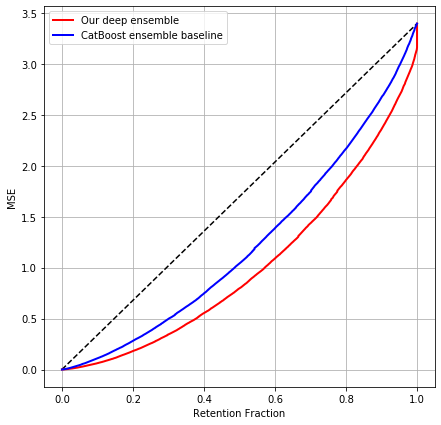

<Figure size 432x288 with 0 Axes>

In [39]:
plt.figure(new_figure_id, figsize=(7, 7))
new_figure_id += 1
if catboost_rejection_mse is None:
    plt.plot([0, 1], [0, retention_mse[-1]], 'k--')
    plt.plot(retention_fractions, retention_mse, linewidth=2)
else:
    last_mse = max(retention_mse[-1], catboost_rejection_mse[-1])
    plt.plot(
        [0, 1],
        [0, last_mse],
        'k--'
    )
    if last_mse > retention_mse[-1]:
        plt.plot(
            retention_fractions.tolist() + [retention_fractions[-1]],
            retention_mse.tolist() + [last_mse],
            color='red', linewidth=2, label='Our deep ensemble'
        )
    else:
        plt.plot(
            retention_fractions,
            retention_mse,
            color='red', linewidth=2, label='Our deep ensemble'
        )
    if last_mse > catboost_rejection_mse[-1]:
        plt.plot(
            retention_fractions,
            catboost_rejection_mse,
            color='blue', linewidth=2, label='CatBoost ensemble baseline'
        )
    else:
        plt.plot(
            retention_fractions.tolist() + [retention_fractions[-1]],
            catboost_rejection_mse.tolist() + [last_mse],
            color='blue', linewidth=2, label='CatBoost ensemble baseline'
        )
plt.ylabel('MSE')
plt.xlabel('Retention Fraction')
plt.grid()
plt.legend(loc='best')
plt.show()
plt.clf()

In [40]:
thresh = 1.0
f_auc, f95, retention_f1 = f_beta_metrics(errors, uncertainties, thresh, beta=1.0)
print(f'F1 score at 95% retention: {f95}')
retention_fractions = np.linspace(0, 1, len(retention_f1))

F1 score at 95% retention: 0.6937173838917867


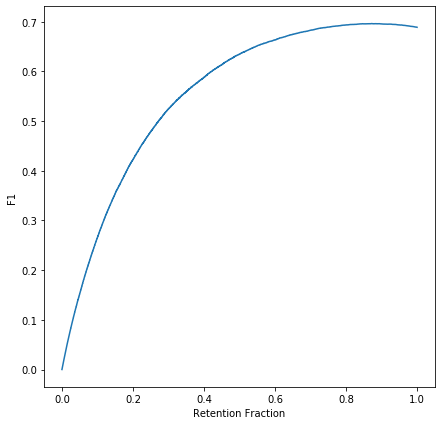

<Figure size 432x288 with 0 Axes>

In [41]:
plt.figure(new_figure_id, figsize=(7, 7))
new_figure_id += 1
plt.plot(retention_fractions, retention_f1)
plt.ylabel('F1')
plt.xlabel('Retention Fraction')
plt.show()
plt.clf()

In [42]:
ids = np.arange(1, inputs.shape[0] + 1)
preds = np.mean(all_preds[:,:,0], axis=0)
df_submission = pd.DataFrame(data={
    'ID' : ids,
    'PRED' : preds,
    'UNCERTAINTY' : uncertainties
})

In [43]:
df_submission.head()

,ID,PRED,UNCERTAINTY
0,1,10.438510,0.616079
1,2,4.866150,0.528755
2,3,26.137645,0.645760
3,4,4.418600,2.852262
4,5,13.519255,1.341938


In [44]:
out_file = os.path.join(model_dir, 'df_submission_dev.csv')
df_submission.to_csv(out_file, index=False)

In [45]:
df_eval = pd.read_csv(eval_name)
df_eval.head()

,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_0_1000,cmc_0_0_0_2_grad,cmc_0_0_0_2_interpolated,cmc_0_0_0_2_next,cmc_0_0_0_2,cmc_0_0_0_500,...,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
0,298.0,-16.337754,7.780000,742.524856,277.912061,-2.039062,275.247046,273.207983,275.247046,256.772266,...,0.0,0.0,0.000000,0.00000,0.0,0.0,-0.558990,-10.608984,0.0,0.0
1,376.0,30.120293,22.282143,723.331713,292.545093,-0.317285,291.059949,290.954187,291.271472,250.076855,...,0.0,0.0,0.000000,0.00000,0.0,0.0,2.099976,8.749994,0.0,0.0
2,83.0,1.232164,14.190000,761.034372,274.791968,-4.542041,273.794141,272.280127,276.822168,257.556323,...,0.0,0.0,0.000000,0.00000,0.0,0.0,0.100006,-10.349982,0.0,0.0
3,5.0,-13.621620,7.946429,764.253037,276.940283,-1.329907,277.582633,277.139331,278.469238,257.171875,...,0.0,0.0,0.000000,0.00000,0.0,0.0,0.125946,-2.341925,0.0,0.0
4,257.0,-20.644158,6.874286,653.700954,285.847852,-0.947852,277.626253,277.310303,278.258154,252.567334,...,0.0,0.0,0.002677,0.00358,0.0,0.0,0.199982,2.350000,26.0,91.0


In [46]:
eval_inputs = df_eval.to_numpy().astype(np.float64)

In [47]:
start_inference_time = time.time()
all_preds = predict_by_ensemble(
    input_data=eval_inputs,
    preprocessing=common_preprocessor,
    postprocessing=postprocessing_scalers,
    ensemble=deep_ensemble,
    minibatch=BATCH_SIZE
)
end_inference_time = time.time()
inference_duration = end_inference_time - start_inference_time
inference_duration *= 1000.0
print('The system predicts each sample from evalset in ' \
      '{0:.3f} msecs.'.format(inference_duration / eval_inputs.shape[0]))

The system predicts each sample from evalset in 0.063 msecs.


In [48]:
all_uncertainty = ensemble_uncertainties_regression(all_preds)
uncertainties = all_uncertainty['tvar']

In [49]:
ids = np.arange(1, len(df_eval) + 1)
preds = np.mean(all_preds[:,:,0], axis=0)
df_submission = pd.DataFrame(data={
    'ID' : ids,
    'PRED' : preds,
    'UNCERTAINTY' : uncertainties
})
df_submission.head()

,ID,PRED,UNCERTAINTY
0,1,2.899178,0.719325
1,2,17.571943,1.277610
2,3,1.696646,0.905027
3,4,2.293385,2.332876
4,5,9.411125,3.744693


In [50]:
out_file = os.path.join(model_dir, 'df_submission.csv')
df_submission.to_csv(out_file, index=False)